In [1]:
#basemap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC 
from scipy.stats import gaussian_kde
from scipy.stats import entropy
from sklearn.metrics import log_loss

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, roc_auc_score

In [3]:
# presence-absence training data
presence_only = pd.read_csv("NSWtrain_po.csv")
presence_absence = pd.read_csv("NSWtrain_bg.csv")

# presence-absence testing data
testing_env = pd.read_csv("NSWtest_env_db.csv")
testing_pa = pd.read_csv("NSWtest_pa_db.csv")
testing_pa = testing_pa[['group','siteid','x','y','nsw14']]

In [4]:
# Subset the target species
spID = "nsw14"
presence_only = presence_only[presence_only['spid'] == spID]

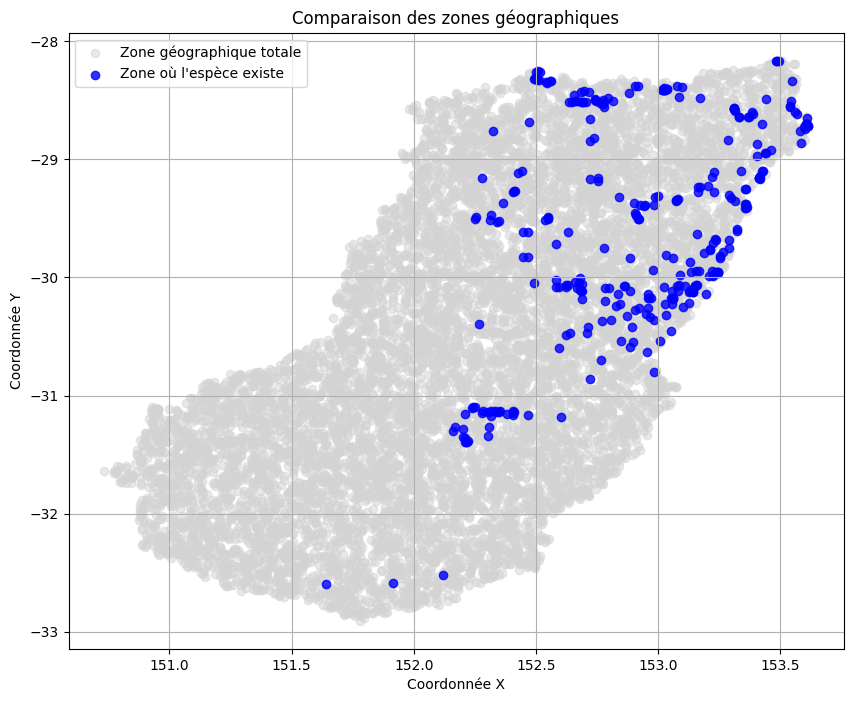

In [5]:
# Visualisation
plt.figure(figsize=(10, 8))

# Zone géographique totale (presence_absence)
plt.scatter(presence_absence['x'], presence_absence['y'], 
            color='lightgrey', label='Zone géographique totale', alpha=0.5)

# Zone de présence uniquement (presence_only)
plt.scatter(presence_only['x'], presence_only['y'], 
            color='blue', label='Zone où l\'espèce existe', alpha=0.8)

plt.xlabel('Coordonnée X')
plt.ylabel('Coordonnée Y')
plt.title('Comparaison des zones géographiques')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Subset uncorrelated covariates
covars = ["cti", "disturb", "mi", "rainann", "raindq", "rugged", "soildepth", "soilfert", 
          "solrad", "tempann", "topo"]
# Subset des colonnes nécessaires
background = presence_absence[covars]
presence = presence_only[covars]
# Copie explicite pour éviter SettingWithCopyWarning
background = background.copy()

In [7]:
columns_to_scale = presence.columns

scaler = StandardScaler()
scaler.fit(np.vstack([
    presence[columns_to_scale].values, 
    background[columns_to_scale].values
]))

presence_scaled = presence.copy()
background_scaled = background.copy()

presence_scaled[columns_to_scale] = scaler.transform(presence[columns_to_scale].values)
background_scaled[columns_to_scale] = scaler.transform(background[columns_to_scale].values)

presence = presence_scaled
background = background_scaled

In [8]:
print(f'The number of presence is', len(presence))
print('Number of background points', len(background))

The number of presence is 315
Number of background points 10000


In [9]:
def eta(alpha,beta, z):
    """
    Calculate the linear predictor: eta = X * beta + alpha
    :param params: [alpha, beta]
    :param z: Feature matrix
    :return: array (number of rows,)
    """
    return np.dot(z, beta) + alpha

In [10]:
def f(z):
    """
    Estimate the density of a DataFrame z using Kernel Density Estimation (KDE).
    :param z: DataFrame or 2D array-like object
    :return: callable density function
    """
    values = z.T.values  # Transpose for KDE input
    kde = gaussian_kde(values)
    return kde

In [11]:
def f1(z_presence, alpha, beta, f_kde):
    """
    Calcule la densité f1(z) = f(z) * exp(alpha + z beta) sur les données de présence.
    :param z_presence: Matrice des caractéristiques pour les points de présence
    :param alpha: Paramètre alpha du modèle
    :param beta: Vecteur des coefficients beta
    :param f_kde: Objet KDE pour évaluer f(z)
    :return: Valeurs de f1(z) pour les points de présence
    """
    eta_vals = eta(alpha,beta,z_presence)
    f_z = f_kde.evaluate(z_presence.T)
    f1_vals = f_z * np.exp(eta_vals)
    return f1_vals

In [12]:
def entropy_loss(beta, z_presence, z_background, lmbda):
    """
    Fonction de perte pour le modèle MaxEnt en exprimant alpha en fonction de beta.
    :param beta: Vecteur des coefficients des covariables
    :param z_presence: Matrice des caractéristiques pour les données de présence
    :param z_background: Matrice des caractéristiques pour les données de fond
    :param lmbda: Paramètre de régularisation
    :return: Valeur scalaire de la perte
    """
    # Nombre de points de présence et de fond
    m = z_presence.shape[0]
    N = z_background.shape[0]
    
    # Calcul de z beta pour les données de présence et de fond
    z_beta_presence = np.dot(z_presence, beta)
    z_beta_background = np.dot(z_background, beta)

    # Approximation de alpha, ici on normalise sur tout L
    alpha = -np.log(np.mean(np.exp(z_beta_background)))
    
    # Terme -E_data[z_i beta]
    loss_data = -np.mean(z_beta_presence)
    
    # Fonction de perte totale
    loss = -alpha + loss_data
    
    # Terme de régularisation
    n = z_presence.shape[1]
    lmbda_vector = (lmbda / np.sqrt(n)) * np.std(z_presence, axis=0)
    reg_term = np.dot(np.abs(beta), lmbda_vector)
    
    total_loss = loss + reg_term
    
    return total_loss


In [13]:
def compute_gradient(beta, z_presence, z_background, lmbda):
    """
    Calculer le gradient de la fonction de perte par rapport à beta.
    :param beta: Vecteur des coefficients beta
    :param z_presence: Matrice des covariables pour les données de présence
    :param z_background: Matrice des covariables pour les données de fond
    :param lmbda: Paramètre de régularisation
    :return: Vecteur gradient de la fonction de perte par rapport à beta
    """
    # Nombre de points de présence et de fond
    m = z_presence.shape[0]
    N = z_background.shape[0]
    
    # Calcul de z beta pour les données de fond
    z_beta_background = np.dot(z_background, beta)
    
    # Utiliser le log-sum-exp trick pour la stabilité numérique
    a_max = np.max(z_beta_background)
    z_beta_background_shifted = z_beta_background - a_max
    exp_z_beta_background = np.exp(z_beta_background_shifted)
    
    # Calcul de la moyenne pondérée des z_background
    sum_exp = np.sum(exp_z_beta_background)
    weights = exp_z_beta_background / sum_exp  # Poids normalisés
    expected_z_background = np.dot(weights, z_background)
    
    # Gradient de -alpha (qui est égal à la moyenne pondérée des z_background)
    grad_alpha = expected_z_background  # Ceci est égal à -d(alpha)/d(beta)
    
    # Gradient de -E_data[z_i beta]
    grad_loss_data = -np.mean(z_presence, axis=0)
    
    # Terme de régularisation
    n = z_presence.shape[1]
    lmbda_vector = (lmbda / np.sqrt(n)) * np.std(z_presence, axis=0)
    grad_reg = lmbda_vector * np.sign(beta)
    
    # Gradient total
    gradient = grad_alpha + grad_loss_data + grad_reg
    
    return gradient


In [14]:
def gradient_descent(z_presence, z_background, lmbda, learning_rate=0.001, max_iter=1000, tol=1e-6):
    """
    Optimiser la fonction de perte en utilisant la descente de gradient.
    :param z_presence: Matrice des covariables pour les données de présence
    :param z_background: Matrice des covariables pour les données de fond
    :param lmbda: Paramètre de régularisation
    :param learning_rate: Taux d'apprentissage
    :param max_iter: Nombre maximal d'itérations
    :param tol: Tolérance pour la convergence
    :return: Vecteur beta optimal
    """
    n_features = z_presence.shape[1]
    beta = np.ones(n_features)  # Initialisation de beta
    
    for iteration in range(max_iter):
        # Calcul du gradient
        gradient = compute_gradient(beta, z_presence, z_background, lmbda)
        
        # Mise à jour de beta
        beta -= learning_rate * gradient
        
        # Calcul de la perte pour suivi
        loss = entropy_loss(beta, z_presence, z_background, lmbda)
        
        # Vérification de la convergence
        grad_norm = np.linalg.norm(gradient)
        if grad_norm < tol:
            print(f"Convergence atteinte en {iteration} itérations.")
            break
        
        if iteration % 100 == 0:
            print(f"Itération {iteration}, perte : {loss}, norme du gradient : {grad_norm}")
    
    return beta

In [15]:
def compute_alpha(beta, z_background):
    """
    Calculer alpha en fonction de beta et des données de fond.
    """
    z_beta_background = np.dot(z_background, beta)
    Z = np.mean(np.exp(z_beta_background))
    alpha = -np.log(Z)
    return alpha

In [16]:
def compute_r(z_presence, alpha, beta, f_kde):
    """
    Calcule la divergence KL pour déterminer la valeur de r.
    :param z_samples: Ensemble d'échantillons z (background ou grille d'évaluation)
    :param z_presence: Matrice des caractéristiques pour les points de présence
    :param alpha: Paramètre alpha du modèle
    :param beta: Vecteur des coefficients beta
    :param f_kde: Objet KDE pour évaluer f(z)
    :return: Valeur de la divergence KL
    """
    # Évaluer f1(z) pour les points de présence
    f1_vals = f1(z_presence, alpha, beta, f_kde)
    
    # Évaluer f(z) pour les mêmes points
    f_z_vals = f_kde.evaluate(z_presence.T)
    
    # Calcul de KL divergence
    kl_values = f1_vals * np.log(f1_vals / f_z_vals)
    kl_divergence = np.sum(kl_values) / len(z_presence)  # Moyenne (approximation)
    
    return kl_divergence

In [17]:
def predict_proba(tau, alpha, beta, z, r):
    """
    Calcule la probabilité Pr(y=1|z).

    Parameters:
    tau (float): Paramètre τ
    alpha (float): Intercepte (biais)
    beta (array-like): Coefficients de régression
    z (array-like): Matrice ou vecteur de caractéristiques
    r (float): Paramètre r

    Returns:
    float: La probabilité calculée
    """
    eta_val = eta(alpha, beta, z) 
    numerator = tau * np.exp(eta_val - r)
    denominator = 1 - tau + tau * np.exp(eta_val - r)
    return numerator / denominator

In [18]:
lmbda = 0.1  # On peut ajuster ici

optimal_beta = gradient_descent(
    z_presence=presence,
    z_background=background,
    lmbda=lmbda,
    learning_rate=0.001,  
    max_iter=1001,
    tol=1e-6
)

# Regarder la matrice hessienne pour voir si on peut utiliser un LR constant

Itération 0, perte : 16.303513901619233, norme du gradient : 31.198543777583538
Itération 100, perte : 3.4736756181080377, norme du gradient : 3.6485228014850892
Itération 200, perte : 2.353262399423792, norme du gradient : 3.0747539839303673
Itération 300, perte : 1.551330861751147, norme du gradient : 2.6005738993636744
Itération 400, perte : 0.9789445542148557, norme du gradient : 2.1972597103640688
Itération 500, perte : 0.5683055639647991, norme du gradient : 1.8678250079808931
Itération 600, perte : 0.26897614675423764, norme du gradient : 1.6026322619122237
Itération 700, perte : 0.04644981553360125, norme du gradient : 1.389152854565824
Itération 800, perte : -0.12243167014876746, norme du gradient : 1.2166712832672644
Itération 900, perte : -0.25327182973501383, norme du gradient : 1.0764481749452182
Itération 1000, perte : -0.354648941842044, norme du gradient : 0.9475317136846595


In [19]:
print('BETA OPTIMAL:')
print(optimal_beta)

BETA OPTIMAL:
cti          0.544005
disturb      0.019485
mi           0.827561
rainann      0.125435
raindq       0.147759
rugged       0.816085
soildepth    0.702015
soilfert    -0.015837
solrad       0.278754
tempann      0.792644
topo         0.733244
dtype: float64


In [20]:
optimal_alpha=compute_alpha(optimal_beta, background)

In [21]:
print("ALPHA OPTIMAL:")
print(optimal_alpha)

ALPHA OPTIMAL:
-1.364912956882049


In [22]:
f_kde = f(background)

# Calcul de r via KL divergence
r = compute_r(presence, optimal_alpha, optimal_beta, f_kde)
print(f"Valeur de r (divergence KL) : {r}")



Valeur de r (divergence KL) : 0.00020729976223109948


In [23]:
tau=0.5

proba_presence = predict_proba(tau, optimal_alpha, optimal_beta, presence, r)

# Prédire les probabilités pour les données de fond
proba_background = predict_proba(tau, optimal_alpha, optimal_beta, background, r)

In [24]:
# Pour les données de fond
background_predictions = presence_absence[['x', 'y']].copy()
background_predictions['probability'] = proba_background

# Pour les données de présence
presence_predictions = presence_only[['x', 'y']].copy()
presence_predictions['probability'] = proba_presence

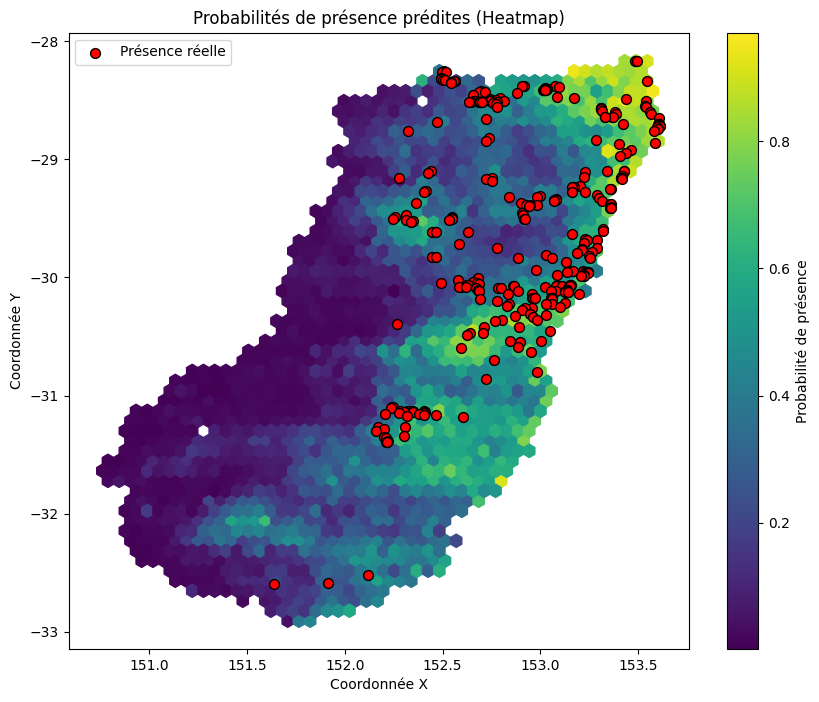

In [25]:
plt.figure(figsize=(10, 8))

# Afficher les probabilités sous forme de hexbin
plt.hexbin(
    background_predictions['x'],
    background_predictions['y'],
    C=background_predictions['probability'],
    gridsize=50,
    cmap='viridis',
    reduce_C_function=np.mean
)

plt.colorbar(label='Probabilité de présence')

# Superposer les points de présence
plt.scatter(
    presence_predictions['x'],
    presence_predictions['y'],
    color='red',
    edgecolor='k',
    label='Présence réelle',
    s=50
)

plt.xlabel('Coordonnée X')
plt.ylabel('Coordonnée Y')
plt.title('Probabilités de présence prédites (Heatmap)')
plt.legend()
plt.show()


In [26]:
tau=0.2

proba_presence = predict_proba(tau, optimal_alpha, optimal_beta, presence, r)

# Prédire les probabilités pour les données de fond
proba_background = predict_proba(tau, optimal_alpha, optimal_beta, background, r)

# Model Calibration

In [ ]:
def compute_log_loss(tau, alpha, beta, presence, background, r):
    """
    Calcule la log-loss pour un tau donné en utilisant les données de présence et de fond.
    
    Parameters:
    tau (float): Paramètre tau à calibrer.
    alpha (float): Intercepte du modèle.
    beta (array-like): Coefficients du modèle.
    presence (array-like): Données de présence (covariables).
    background (array-like): Données de fond (covariables).
    r (float): Paramètre r utilisé dans predict_proba.
    
    Returns:
    float: Valeur de la log-loss.
    """
    # Prédire les probabilités pour les données de présence (étiquette 1)
    proba_presence = predict_proba(tau, alpha, beta, presence, r)
    
    # Prédire les probabilités pour les données de fond (étiquette 0)
    proba_background = predict_proba(tau, alpha, beta, background, r)
    
    # Combiner les probabilités et les étiquettes vraies
    proba = np.concatenate([proba_presence, proba_background])
    y_true = np.concatenate([np.ones(len(proba_presence)), np.zeros(len(proba_background))])
    
    loss = log_loss(y_true, proba)
    return loss


In [ ]:
from scipy.optimize import minimize_scalar
# implementer avec d'autres metriques
def find_optimal_tau(alpha, beta, presence, background, r):
    """
    Trouve le tau optimal qui minimise la log-loss.
    
    Parameters:
    alpha (float): Intercepte du modèle.
    beta (array-like): Coefficients du modèle.
    presence (array-like): Données de présence (covariables).
    background (array-like): Données de fond (covariables).
    r (float): Paramètre r utilisé dans predict_proba.
    
    Returns:
    float: Valeur optimale de tau.
    """
    # Fonction objective à minimiser
    def objective(tau):
        return compute_log_loss(tau, alpha, beta, presence, background, r)
    
    # Effectuer l'optimisation sur l'intervalle [0, 1]
    result = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    
    if result.success:
        return result.x
    else:
        raise ValueError("L'optimisation de tau n'a pas réussi.")


In [ ]:
tau_optimal = find_optimal_tau(optimal_alpha, optimal_beta, presence, background, r)
print("TAU OPTIMAL :")
print(tau_optimal)

In [ ]:
# Prédire les probabilités pour les données de présence
proba_presence = predict_proba(tau_optimal, optimal_alpha, optimal_beta, presence, r)

# Prédire les probabilités pour les données de fond
proba_background = predict_proba(tau_optimal, optimal_alpha, optimal_beta, background, r)


In [ ]:
plt.figure(figsize=(10, 8))

# Afficher les probabilités sous forme de hexbin
plt.hexbin(
    background_predictions['x'],
    background_predictions['y'],
    C=background_predictions['probability'],
    gridsize=50,
    cmap='viridis',
    reduce_C_function=np.mean
)

plt.colorbar(label='Probabilité de présence')

# Superposer les points de présence
plt.scatter(
    presence_predictions['x'],
    presence_predictions['y'],
    color='red',
    edgecolor='k',
    label='Présence réelle',
    s=50
)

plt.xlabel('Coordonnée X')
plt.ylabel('Coordonnée Y')
plt.title('Probabilités de présence prédites (Heatmap) Avec Tau optimal')
plt.legend()
plt.show()


# Out of sample

In [ ]:
# Load the presence-absence testing data
testing_env = pd.read_csv("NSWtest_env_db.csv")
testing_pa = pd.read_csv("NSWtest_pa_db.csv")
testing_pa = testing_pa[['group','siteid','x','y','nsw14']]

In [ ]:
X_test=testing_env[presence.columns]
X_test=scaler.transform(X_test.values)

presence_test= testing_pa[testing_pa['nsw14']==1]
y_test=testing_pa['nsw14']
# Prédire les probabilités pour les données de présence
proba_test = predict_proba(tau_optimal, optimal_alpha, optimal_beta, X_test, r)

In [ ]:
# Pour les données de fond
background_grid = presence_absence[['x', 'y']].copy()
background_grid['probability'] = 0

# Pour les données de présence
test_predictions = testing_pa[['x', 'y']].copy()
test_predictions['probability'] = proba_test


In [ ]:
plt.figure(figsize=(10, 8))

# Afficher les probabilités sous forme de hexbin
plt.hexbin(
    test_predictions['x'],
    test_predictions['y'],
    C=test_predictions['probability'],
    gridsize=50,
    cmap='viridis',
    reduce_C_function=np.mean
)

plt.colorbar(label='Probabilité de présence')

# Superposer les points de présence
plt.scatter(
    presence_test['x'],
    presence_test['y'],
    color='red',
    edgecolor='k',
    label='Présence réelle',
    s=50
)

plt.xlabel('Coordonnée X')
plt.ylabel('Coordonnée Y')
plt.title('Probabilités de présence prédites (Heatmap)')
plt.legend()
plt.show()


In [ ]:
log_loss = -np.mean(y_test * np.log(proba_test) + (1 - y_test) * np.log(1 - proba_test))
print(f"Log Loss: {log_loss}")
# faire plutot un histo

In [ ]:
roc_auc = roc_auc_score(y_test, proba_test)
print(f"ROC AUC: {roc_auc}")

In [ ]:
from sklearn.metrics import roc_curve

# Calcul des scores AUC
roc_auc = roc_auc_score(y_test, proba_test)

# Calcul des courbes ROC
fpr, tpr, thresholds = roc_curve(y_test, proba_test)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()
